# Import module

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 100)

import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
sc.settings.set_figure_params(dpi=300)

# Prepare function

In [3]:
def rank_genes_groups_to_df(adata, cell):
    
    dic = adata.uns['rank_genes_groups'] 
    
    df = pd.DataFrame({
        'names' : dic['names'][cell],
        'scores' : dic['scores'][cell],
        'pvals' : dic['pvals'][cell],
        'pvals_adj' : dic['pvals_adj'][cell],
        'logfoldchanges' : dic['logfoldchanges'][cell]
    })
    
    return df

# rank_genes_groups_to_df(sanp, 'SAN_P_cell')

In [4]:
# based on sctk.pseudo_bulk
# https://github.com/Teichlab/sctk/blob/c6d0c7b2ffe3243d83d743a3beb04680150cb6e7/sctk/_utils.py#L632
import scipy.sparse as sp

def get_exp_proportion(
        adata, groupby, use_rep='X'):
    """get proportion of expressing cells from grouped sc data
    """
    if adata.obs[groupby].dtype.name == 'category':
        group_attr = adata.obs[groupby].values
        groups = adata.obs[groupby].cat.categories.values
    else:
        group_attr = adata.obs[groupby].astype(str).values
        groups = np.unique(group_attr)
    n_level = len(groups)
    
    if use_rep == 'X':
        x = adata.X
        features = adata.var_names.values
    elif use_rep == 'raw':
        x = adata.raw.X
        features = adata.raw.var_names.values
    elif use_rep in adata.layers.keys():
        x = adata.layers[use_rep]
        features = adata.var_names.values
    elif use_rep in adata.obsm.keys():
        x = adata.obsm[use_rep]
        features = np.arange(x.shape[1])
    elif (isinstance(use_rep, np.ndarray) and
            use_rep.shape[0] == adata.shape[0]):
        x = use_rep
        features = np.arange(x.shape[1])
    else:
        raise KeyError(f'{use_rep} invalid.')
    
    summarised = np.zeros((n_level, x.shape[1]))
    for i, grp in enumerate(groups):
        k_grp = group_attr == grp
        if sp.issparse(x):
            summarised[i] = np.sum(x[k_grp,:]>0,axis=0)/x[k_grp,:].shape[0]
        else:
            print('X is not sparce')
            
            ################# added here #################
            summarised[i] = np.sum(x[k_grp,:]>0,axis=0)/x[k_grp,:].shape[0]
            ##############################################
            
    return pd.DataFrame(summarised.T, columns=groups, index=features)

# Load pyScenic regulon

In [5]:
# pyscenic output
import yaml
with open("/nfs/team205/heart/pyscenic/regulons/adult_multiome_aCM_regulons.yaml", "r") as f:
    regulons_all = yaml.safe_load(f)

In [6]:
# select positive or negative regulons
pos_or_neg = '(-)'

regulons = {}
for k,v in regulons_all.items():
    if pos_or_neg in k:
        regulons[k.replace(pos_or_neg,'')] = v
len(regulons.keys())

88

# Load ATAC network

In [7]:
# Identified targetable genes basd on ATAC data
import json

path = '/nfs/team205/heart/anndata_objects/8regions/ArchR/project_output/TF_downstreamGene/AtrialCardiomyocyte_p2gCorr-negative--0.2.json'

with open(path) as f:
    atac_nw = json.load(f)
    
len(atac_nw)

870

# Load RNA data and prepare DEGs and "expressed genes"

## Load data and preprocess

In [8]:
# read in rna anndata
adata_rna = sc.read_h5ad('/nfs/team205/heart/anndata_objects/8regions/RNA_adult-8reg_full_raw_cellstate-annotated.h5ad')

# set gene name as var_names 
adata_rna.var['gene_id']=adata_rna.var_names.copy()
adata_rna.var.set_index('gene_name-new',inplace=True)
adata_rna.var_names=adata_rna.var_names.astype('str')
adata_rna.var_names_make_unique()

# remove unclassified cells
adata_rna=adata_rna[adata_rna.obs['cell_state']!='unclassified']

# filter and lognormalised
sc.pp.filter_genes(adata_rna, min_cells=3)
sc.pp.normalize_total(adata_rna, target_sum=1e4)
sc.pp.log1p(adata_rna)

adata_rna

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


AnnData object with n_obs × n_vars = 690558 × 31460
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches'
    var: 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original', 'gene_id', 'n_cells'
    uns: 'age_colors', 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_type_colors', 'donor_colors', 'do

In [9]:
# subset only multiome data (since 'P_cell' is purely from multiome)
adata_rna = adata_rna[adata_rna.obs['modality']=='Multiome-RNA']

In [10]:
# combine P cells
adata_rna.obs['cell_state_2'] = adata_rna.obs['cell_state'].astype('str')
adata_rna.obs.replace({'cell_state_2':{
    'AVN_P_cell':'P_cell',
    'SAN_P_cell':'P_cell'
}}, inplace=True)

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  


In [11]:
# subset cell types of interest
target_celltype = 'P_cell'
celltype_group = ['P_cell','aCM1','aCM2','aCM3','aCM4','aCM5']

adata_rna = adata_rna[adata_rna.obs['cell_state_2'].isin(celltype_group)]

In [12]:
adata_rna.obs['modality'].value_counts()

Multiome-RNA    19337
Name: modality, dtype: int64

In [13]:
adata_rna.obs['cell_state_2'].value_counts()

aCM2      9083
aCM1      5004
aCM4      3388
aCM3      1462
P_cell     400
Name: cell_state_2, dtype: int64

## Prepare DEGs

In [14]:
%%time
# DEG calculation
sc.tl.rank_genes_groups(adata_rna, 'cell_state_2', 
                        groups=[target_celltype], reference='rest', 
                        method='wilcoxon')

degs_df = rank_genes_groups_to_df(adata_rna, target_celltype)

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


CPU times: user 28.9 s, sys: 3.8 s, total: 32.7 s
Wall time: 33.2 s


In [15]:
# select degs (for TF)
pval_adj_thresh = 0.05
degs_df = degs_df[degs_df['pvals_adj'] < pval_adj_thresh]

rna_degs_UP = list(degs_df[degs_df['logfoldchanges'] > 0]['names'])
rna_degs_DOWN = list(degs_df[degs_df['logfoldchanges'] < 0]['names'])

In [16]:
len(rna_degs_UP)

847

In [17]:
len(rna_degs_DOWN)

691

## Prepare expressing genes in P cells (more than 10%)

In [18]:
# select genes which has larger proportion in a group of interest 
# here 10%
exp_prop = get_exp_proportion(adata_rna, groupby='cell_state_2')
exp_genes = exp_prop.index[exp_prop['P_cell'] > 0.1]
len(exp_genes)

8660

# Select key TFs and TGs and prepare a dataframe

* TGs
    - <s>Expressed in more then 10% of P cells</s> # since this is repressing network
    - Differentially expressed (**negatively**) in P cells compared with other aCMs
* TFs
    - Expressed in more then 10% of P cells
    - Differentially expressed (**positively**) in P cells compared with other aCMs
    - Targets the selected TGs

In [19]:
# select target genes and TFs from the regulons
key_TF_TG = {}
for tf, tg in regulons.items():
    if (tf in rna_degs_UP)&(tf in exp_genes): # UP-regulated genes for TF
        key_tgs = list(set(tg).intersection(rna_degs_DOWN)) # intersectin with only degs but not with exp_genes, since this is repressing network
        if len(key_tgs)>0:
            key_TF_TG[tf] = key_tgs    
        del key_tgs

In [20]:
# prepare dataframe of TF and TGs and save
tftg_df = pd.DataFrame({'TF':[],'TF_logFC':[],'TargetGene':[],'TargetGene_logFC':[],'ATAC_interaction':[]})
for k,v in key_TF_TG.items():
    # get logFC for TF
    tf_logfc = degs_df.set_index('names').loc[k,'logfoldchanges']
    for vv in v:
        # get logFC for TG
        tg_logfc = degs_df.set_index('names').loc[vv,'logfoldchanges']
        
        # check whether the interaction in ATAC-network and make dataframe
        if k in atac_nw.keys():
            atac_nw_tg = atac_nw[k]
            if vv in atac_nw_tg:
                df = pd.DataFrame({'TF':[k],'TF_logFC':[tf_logfc],'TargetGene':[vv],'TargetGene_logFC':[tg_logfc],'ATAC_interaction':['Yes']})
            else:
                df = pd.DataFrame({'TF':[k],'TF_logFC':[tf_logfc],'TargetGene':[vv],'TargetGene_logFC':[tg_logfc],'ATAC_interaction':['No']})
        else:
            df = pd.DataFrame({'TF':[k],'TF_logFC':[tf_logfc],'TargetGene':[vv],'TargetGene_logFC':[tg_logfc],'ATAC_interaction':['No']})
        
        # df = pd.DataFrame({'TF':[k],'TF_logFC':[tf_logfc],'TargetGene':[vv],'TargetGene_logFC':[tg_logfc],'ATAC_interaction':[np.nan]})
        # concatenate
        tftg_df = pd.concat([tftg_df,df],axis=0)
print(len(tftg_df))

# save
tftg_df.to_csv('/home/jovyan/projects/P61_Adult-heart_pyscenic/notebooks/csv/Pcell_GRN_DOWN_corr02.csv', index=False)

227


In [21]:
tftg_df

,TF,TF_logFC,TargetGene,TargetGene_logFC,ATAC_interaction
0,ATF7,0.371762,TACC2,-1.215219,No
0,ATF7,0.371762,TIMP3,-0.966176,Yes
0,ATF7,0.371762,HLF,-1.039463,No
0,ATF7,0.371762,SMAD7,-0.799943,No
0,ATF7,0.371762,WSB1,-0.359701,No
...,...,...,...,...,...
0,THRB,0.545013,EPHA5,-2.324766,No
0,THRB,0.545013,NAV2,-0.400714,Yes
0,THRB,0.545013,PRUNE2,-1.465091,No
0,THRB,0.545013,BHLHE40,-1.512007,No


In [22]:
key_TF_TG.keys()

dict_keys(['ATF7', 'CREB5', 'CUX1', 'ELK4', 'ESRRG', 'GLIS3', 'NFIB', 'NR6A1', 'SHOX2', 'SOX9', 'TBX3', 'TCF4', 'THRB', 'ZNF208'])

# Plot Network

In [23]:
# set a threshold of logFC (for both TF and TG) for plotting
FC_thresh_for_plot_UP = 0.5
FC_thresh_for_plot_DOWN = 0.5

df = tftg_df[(tftg_df['TF_logFC'] > FC_thresh_for_plot_UP)&(tftg_df['TargetGene_logFC'] < FC_thresh_for_plot_DOWN)]

# make TF:TG dictionary for plotting
key_TF_TG_plot = {}
for tf in set(df['TF']):
    key_TF_TG_plot[tf] = list(df[df['TF']==tf]['TargetGene'])

len(df)

175

In [24]:
# definition of function
def generate_edges(graph):
    edges = []
  
    # for each node in graph
    for node in graph:
          
        # for each neighbour node of a single node
        for neighbour in graph[node]:
              
            # if edge exists then append
            edges.append((node, neighbour))
    return edges

In [25]:
# prepare GPCR and Ion channel genes
# for coloring TG nodes
gpcr = list(pd.read_csv('/nfs/team205/kk18/data/geneset/HGNC/HGNC_GID139_G-protein-coupled-receptors.txt',sep='\t')['Approved symbol'].unique())
ion = list(pd.read_csv('/nfs/team205/kk18/data/geneset/HGNC/HGNC_GID177_Ion-channels.txt',sep='\t')['Approved symbol'].unique())
tfs = list(pd.read_csv('/nfs/team205/kk18/data/geneset/humanTFs_Lambert_Cell_2018.csv')['Gene'].unique())

# solutecarrier = list(pd.read_csv('/nfs/team205/kk18/data/geneset/HGNC/HGNC_GID752_SoluteCarriers.txt',sep='\t')['Approved symbol'].unique())
# snare = list(pd.read_csv('/nfs/team205/kk18/data/geneset/HGNC/HGNC_GID1124_SNAREs.txt',sep='\t')['Approved symbol'].unique())

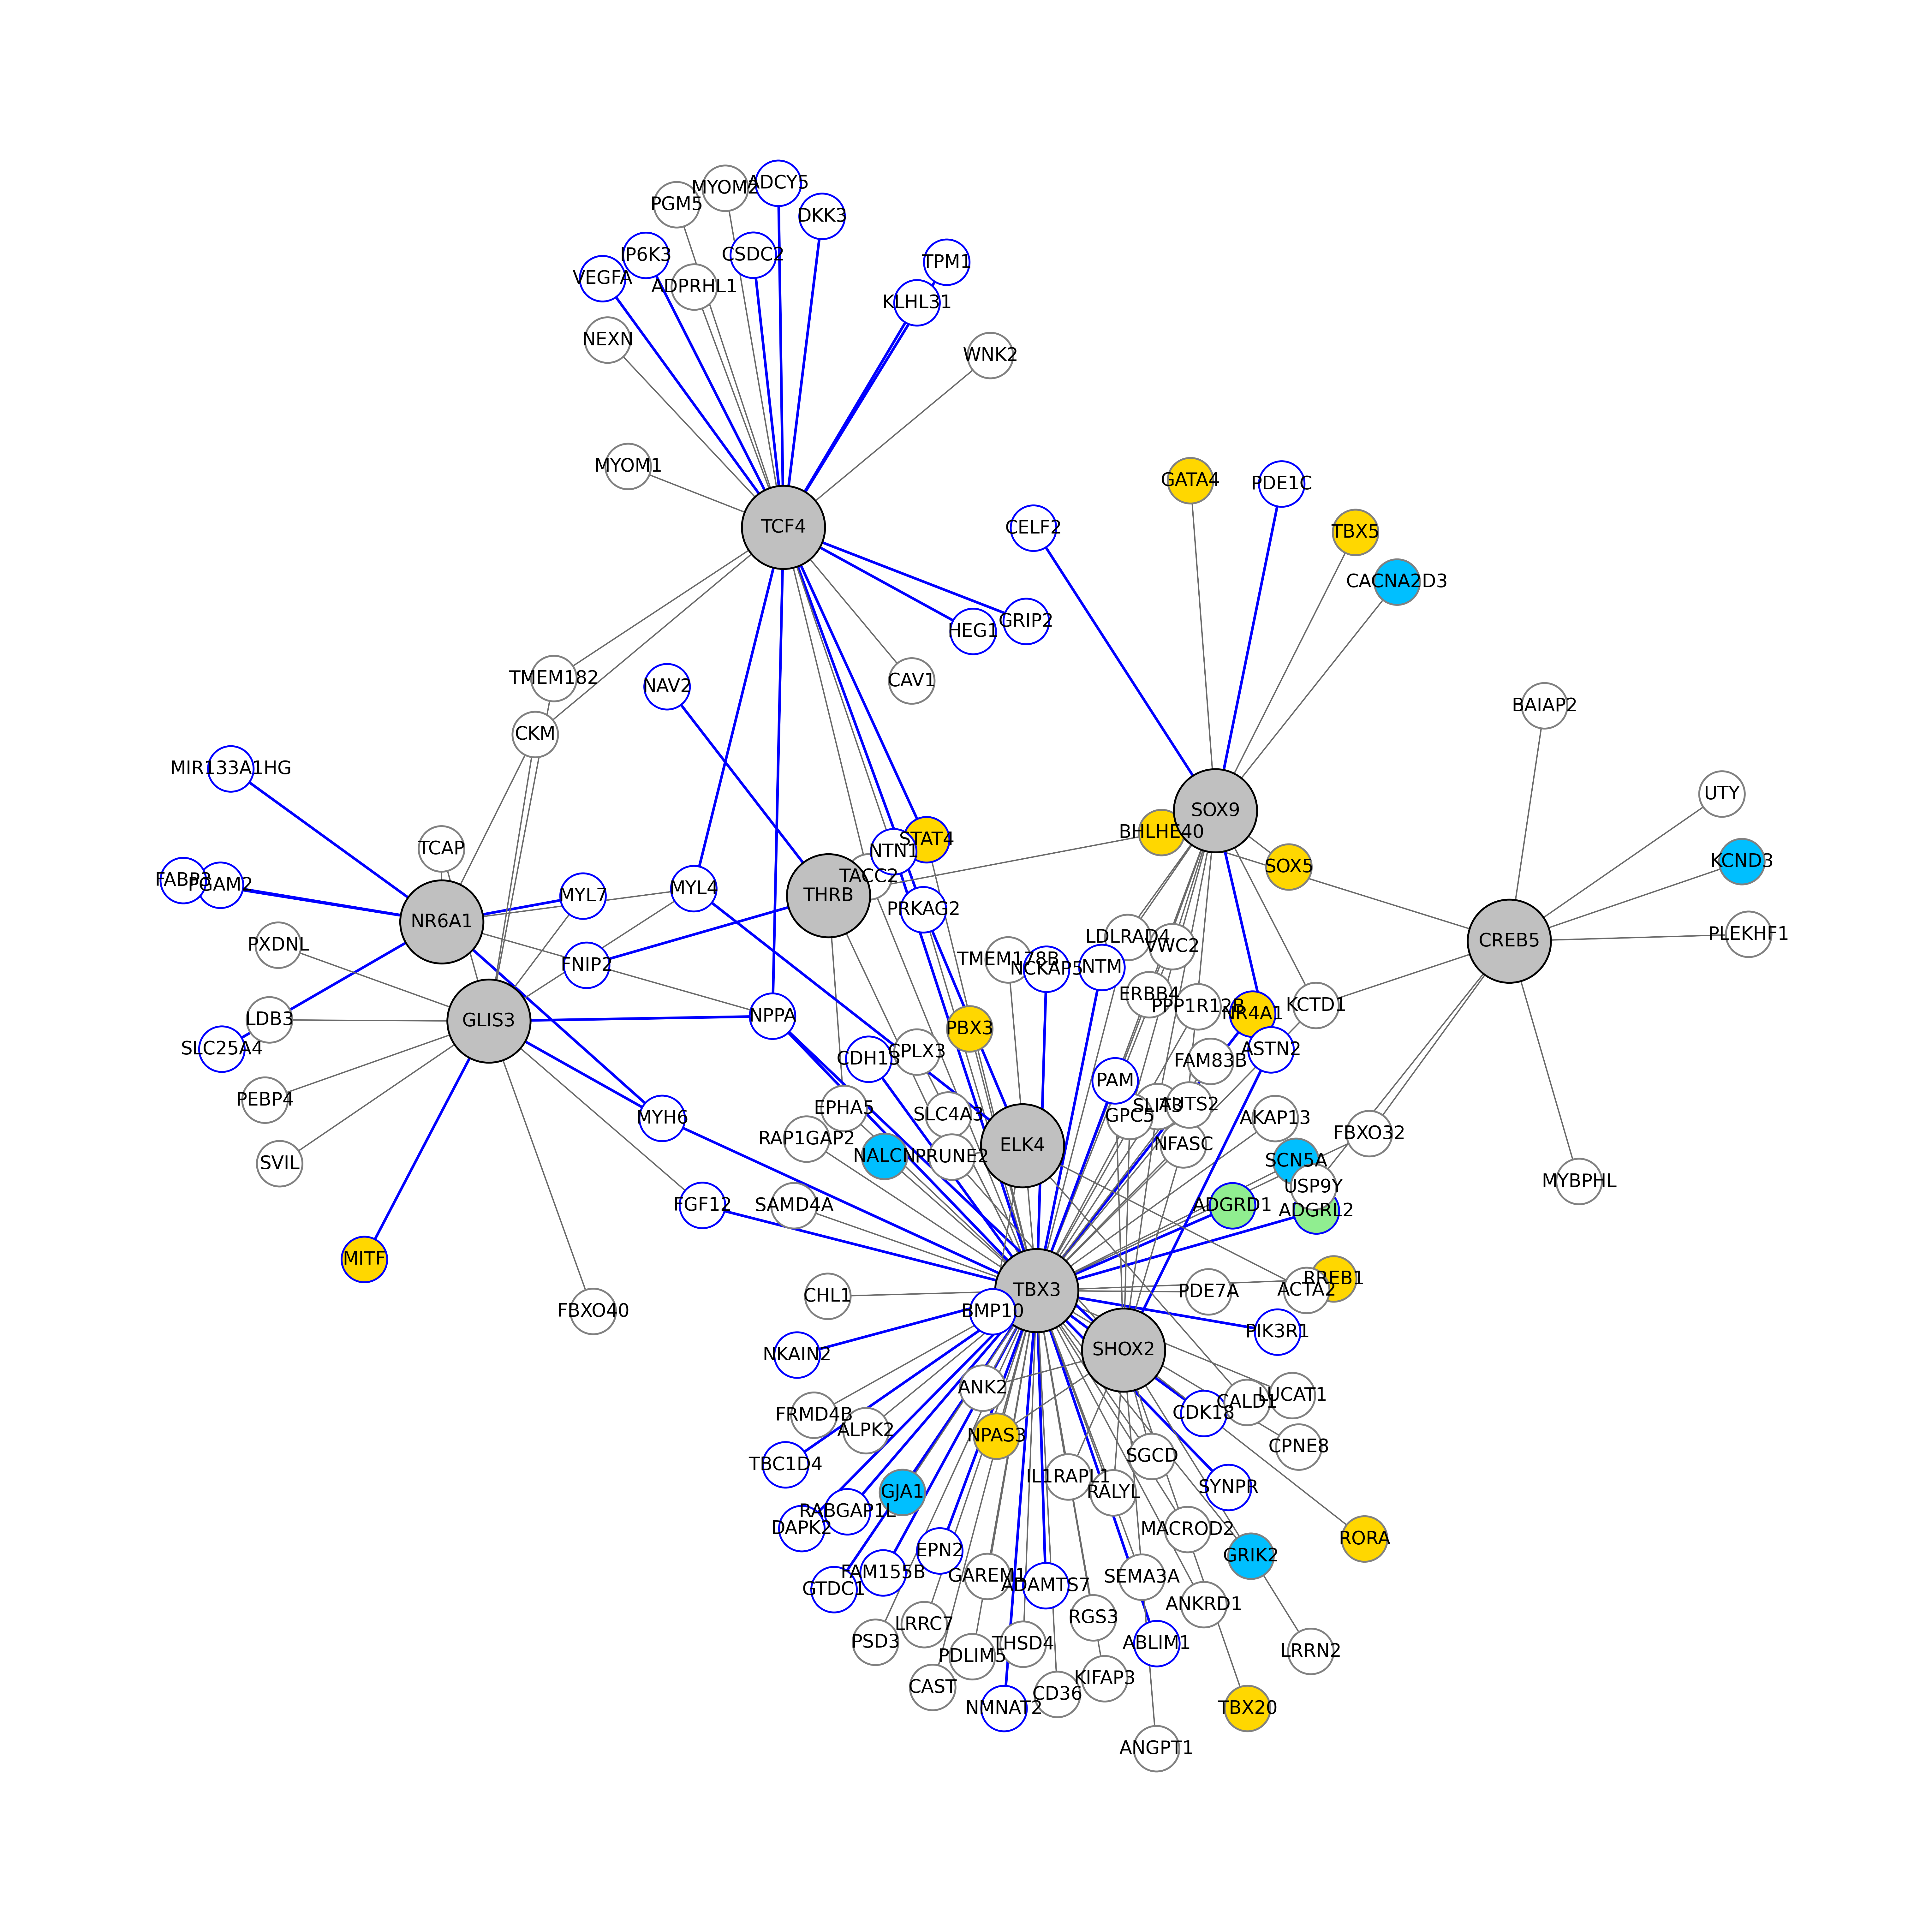

In [36]:
import networkx as nx
import random
random.seed(12)        # or any integer
import numpy
numpy.random.seed(1)
import math

G = nx.Graph()
G.add_edges_from(generate_edges(key_TF_TG_plot))

col_map = {}
size_map = {}
edgecolors_map = {}
for k in key_TF_TG_plot.keys():
    col_map[k]='silver'
    size_map[k]=1000
    edgecolors_map[k]='black'  # '#FF000000'
    
colors = [col_map.get(node, 'white') for node in G.nodes()]
# add color if gpcr
colors = ['lightgreen' if tup[1] in gpcr else tup[0] for tup in zip(colors,G.nodes())]
# add color if ion channel
colors = ['deepskyblue' if tup[1] in ion else tup[0] for tup in zip(colors,G.nodes())]

colors = ['gold' if (tup[1] in tfs)&(tup[1] not in key_TF_TG_plot.keys()) else tup[0] for tup in zip(colors,G.nodes())]

sizes = [size_map.get(node, 300) for node in G.nodes()]

# change edgecolor if its in ATAC-network
## edges of the nodes
genes_matchs_with_atacnetwork = []
for k,v in key_TF_TG_plot.items():
    if k in atac_nw.keys():
        g = list(set(v).intersection(atac_nw[k]))
        genes_matchs_with_atacnetwork = genes_matchs_with_atacnetwork + g
genes_matchs_with_atacnetwork = list(set(genes_matchs_with_atacnetwork))
edgecolors= [edgecolors_map.get(node, 'grey') for node in G.nodes()]
edgecolors = ['blue' if (tup[1] in genes_matchs_with_atacnetwork)&(tup[1] not in key_TF_TG_plot.keys()) else tup[0] for tup in zip(edgecolors,G.nodes())]
## edges between nodes
edges = G.edges(data=True)
edge_color_list = []
edge_width_list = []
for x in edges:
    if x[0] in key_TF_TG_plot.keys():
        if x[0] in atac_nw.keys():
            if x[1] in atac_nw[x[0]]:
                edge_color_list.append('blue')
                edge_width_list.append(1)
            else:
                edge_color_list.append('dimgrey')
                edge_width_list.append(0.5)
        else:
            edge_color_list.append('dimgrey')
            edge_width_list.append(0.5)
    elif x[1] in key_TF_TG_plot.keys():
        if x[1] in atac_nw.keys():
            if x[0] in atac_nw[x[1]]:
                edge_color_list.append('blue')
                edge_width_list.append(1)
            else:
                edge_color_list.append('dimgrey')
                edge_width_list.append(0.5)
        else:
            edge_color_list.append('dimgrey')
            edge_width_list.append(0.5)

pos = nx.spring_layout(G,k=0.25,scale=2)
#https://networkx.org/documentation/latest/reference/generated/networkx.drawing.layout.spring_layout.html

plt.figure(figsize = (10,10))
nx.draw(G, pos, node_color = colors, node_size = sizes, edgecolors=edgecolors,
       with_labels = True, width=0.4, font_size=7, linewidths=0.7)
# https://networkx.org/documentation/stable/auto_examples/drawing/plot_labels_and_colors.html
nx.draw_networkx_edges(G, pos, edge_color=edge_color_list, width=edge_width_list)
plt.savefig('/home/jovyan/projects/P61_Adult-heart_pyscenic/notebooks/figures/Pcell_GRN_DOWN_corr02.pdf')
plt.show()